In [2]:
#loading libraries and dependencies
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

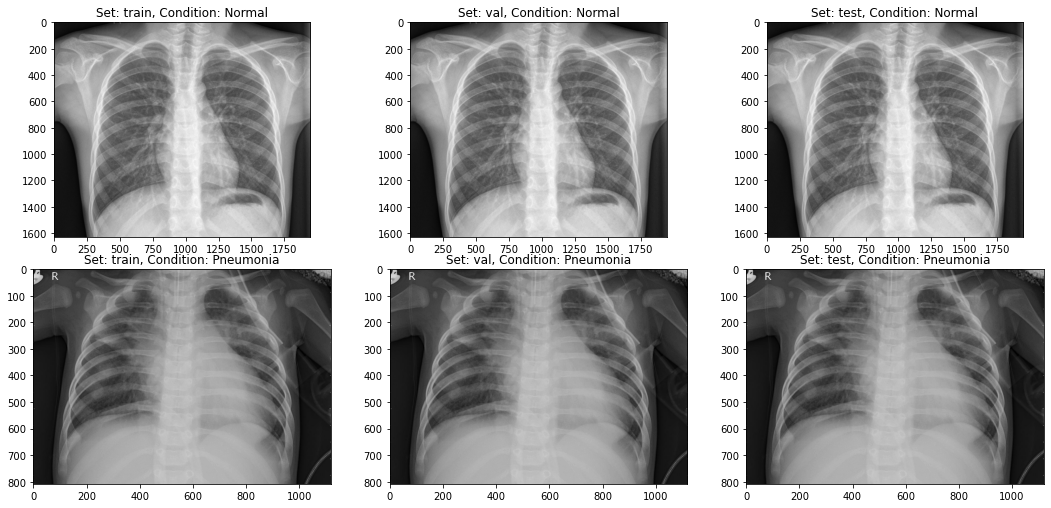

In [23]:
#displaying normal and pneumonia images to compare
input_path = '../Downloads/chest_xray/chest_xray/test'
#NOTE: for some reason the val set does not work here, only the test and train sets display correctly

fig, ax = plt.subplots(2, 3, figsize = (15, 7))
ax = ax.ravel() #ravel func returns continuous flattened array
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path
    ax[i].imshow(plt.imread(set_path+'/NORMAL/' + os.listdir(set_path +'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path + '/PNEUMONIA/' + os.listdir(set_path + '/PNEUMONIA') [0]), cmap = 'gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [24]:
#splitting the data into train, test, and validation sets
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + '/NORMAL'))
    n_pneumonia = len(os.listdir(input_path + '/PNEUMONIA'))
    print('Set: {}, normal impages: {}, pneumonia images: {}'.format(_set, n_normal, n_pneumonia))

Set: train, normal impages: 234, pneumonia images: 390
Set: val, normal impages: 234, pneumonia images: 390
Set: test, normal impages: 234, pneumonia images: 390


In [25]:
#the following function does some data augmentation, it feeds the training and test set images to the network
#data augmentation increases the size of the training set and allows the network to "see" more diversified, 
#but still representative, data points during trainging

def process_data(img_dims, batch_size):
    #data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    #ImageDataGenerator generates batches of tensor image data with real-time data
    #rescale method: default is 0, if set, data is multiplied by the value provided (after performing all other transformations)
    #zoom_range method: range for random zoom, used to zoom the image
    #vertical_flip method: randomly flips inputs vertically
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    #this is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory( directory=input_path, 
                                                  target_size=(img_dims, img_dims), 
                                                  batch_size=batch_size, 
                                                  class_mode='binary', 
                                                  shuffle=True)
    test_gen = test_val_datagen.flow_from_directory( directory=input_path, 
                                                    target_size=(img_dims, img_dims), 
                                                    batch_size=batch_size, 
                                                    class_mode='binary', 
                                                    shuffle=True)
    #the flow_from_directory() method allows you to read the images directly from the directory and augment
    #them while the neural network model is learning on the training data
    #it takes a pth of a directory and generates batches of augmented data; this method assumes that
    #the root directory contains at least two folders, one for train and one for the test

    #I will be making predictions off of the test set in one batch size
    #this is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []
    
    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + cond)):
            img = plt.imread(input_path + cond + img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond == '/NORMAL/':
                label = 0
            elif cond == '/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels
    

In [26]:
#Now we're defining some constants for later usage
img_dims = 150
epochs = 10
batch_size = 32

train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Building the Model

######
1. Five convolution blocks were used, comprised of convulutional layer, max-pooling, and batch-normalization
2. On top of it a flatten layer is used, followed by four fully connected layers
3. Dropouts have been used in between to reduce over-fitting
4. Activation function was Relu throughout except for the last layers where it was Sigmoid as this is a binary classification problem
5. Adam has been used as teh optimizer and cross-entropy as the loss

###### Definitions
ModelCheckpoint: when training require a lot of time to achieve a good result, often many iterations are required. In this case, it is better to save a copy of the best performing model only when an epoch that improves the metrics ends
EarlyStopping: sometimes during training we can notice that the generalization gap (i.e., the different between training and validation error) starts to increase, instead of decresing. This is a symptom of overfitting that can be solved in many ways (reducing model capacity, increasing training data, data augmentation, regularization, dropout, etc.). Often a practical and efficient solution is to stop traingin when the generalization gap is getting worse

In [27]:
from keras.layers import LeakyReLU
inputs = Input(shape=(img_dims, img_dims, 3))

#first conv block
#Conv2d performs a convolution operation on the 2D matrix that is provided to it
#This means that matrix invrsion, and MAC operations on the matrix, can be done through single function
#included in torch
x = Conv2D(filters = 16, kernel_size = (3, 3), activation = 'LeakyReLU', padding = 'same')(inputs)
x = Conv2D(filters = 16, kernel_size = (3, 3), activation = 'LeakyReLU', padding = 'same')(x)
x = MaxPool2D(pool_size = (2, 2))(x)

#second conv block
#SeparableConv2D is a variation of the traditional convolution; it performs a deapthwise spatial convolution
#followed by a pointwise convolution which mixes together the resulting output channels; it was proposed
#to make the computation faster
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='LeakyReLU', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='LeakyReLU', padding='same')(x)
#BatchNormalization standardizes the inputs to a layer for each mini-batch; has the same effect of
#stabalizing and learning process and dramatically reduces the number of training epochs required to train
#deep networks
x = BatchNormalization()(x)
#The opjective of Max Pooling is to down-sample an input representation (e.g., an image), reducing its
#dimensionality and allowing for assumptions to be made about features contained in the sub-regions binned
x = MaxPool2D(pool_size = (2, 2))(x)

#third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='LeakyReLU', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='LeakyReLU', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = (2, 2))(x)

#fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='LeakyReLU', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='LeakyReLU', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = (2, 2))(x)
x = Dropout(rate = 0.2)(x)

#fifth conv block
x = Conv2D(filters = 256, kernel_size = (3, 3), activation = 'LeakyReLU', padding = 'same')(x)
x = Conv2D(filters = 256, kernel_size = (3, 3), activation = 'LeakyReLU', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = (2, 2))(x)
x = Dropout(rate = 0.2)(x)

#FC layer
x = Flatten()(x)
x = Dense(units = 512, activation = 'LeakyReLU')(x)
x = Dropout(rate = 0.7)(x)
x = Dense(units = 128, activation = 'LeakyReLU')(x)
x = Dropout(rate = 0.5)(x)
x = Dense(units = 64, activation = 'LeakyReLU')(x)
X = Dropout(rate = 0.3)(x)

#output layer
output = Dense(units = 1, activation = 'sigmoid')(x)

#creating model and compiling
model = Model(inputs = inputs, outputs = output)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

#callbacks
checkpoint = ModelCheckpoint(filepath='best_weight.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 2, verbose = 2, model = 'max')
early_stop = EarlyStopping(monitor = 'val_loss', min_delta=0.1, patience=1, mode = 'min')

######
Next, the model will be trained for 10 epochs (number of passes of the entire training dataset that machine learning algorithm will complete) with a batch size of 32.
Note: usually a higher batch size gives better results but at the expense of higher computational burden

In [28]:
hist = model.fit_generator(train_gen, steps_per_epoch=train_gen.samples // batch_size,
                           epochs = epochs, validation_data=test_gen,
                           validation_steps=test_gen.samples // batch_size, callbacks = [checkpoint, lr_reduce])

/var/folders/8r/ws2jnzhd1x562k7_k9npqxdc0000gn/T/ipykernel_9856/431021389.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train_gen, steps_per_epoch=train_gen.samples // batch_size,


Epoch 1/10
19/19 [==============================] - 22s 1s/step - loss: 0.5998 - accuracy: 0.7111 - val_loss: 0.7007 - val_accuracy: 0.3734 - lr: 0.0010
Epoch 2/10
19/19 [==============================] - 21s 1s/step - loss: 0.4671 - accuracy: 0.7736 - val_loss: 0.7394 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 3/10
19/19 [==============================] - ETA: 0s - loss: 0.4565 - accuracy: 0.8159
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
19/19 [==============================] - 21s 1s/step - loss: 0.4565 - accuracy: 0.8159 - val_loss: 0.9308 - val_accuracy: 0.3766 - lr: 0.0010
Epoch 4/10
19/19 [==============================] - 21s 1s/step - loss: 0.4387 - accuracy: 0.8057 - val_loss: 0.8838 - val_accuracy: 0.3750 - lr: 3.0000e-04
Epoch 5/10
19/19 [==============================] - ETA: 0s - loss: 0.3788 - accuracy: 0.8395
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
19/19 [==============================] - 21s 1s/step - 

##### Visualizing the loss and accuracy plots

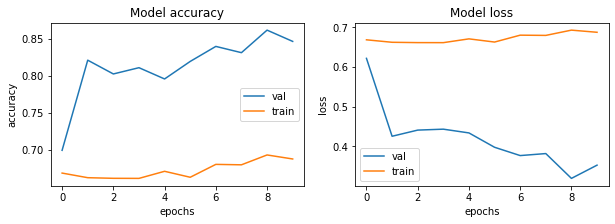

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_loss'])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['val','train'])
    
#the model is not converging, unsure why but working on fixing this

##### Plotting the confusion matrix and getting additional results including precision, recall, F1 score, and accuracy

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print("Confusion matrix:")
print(cm)

print()
print("Test metrics:")
precision = tp / (tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print()
print("Train metric:")
print('Train acc: {}'.format(np.round(hist.history['val_accuracy'][-1])*100, 2))

Confusion matrix:
[[  0 234]
 [  0 390]]

Test metrics:
Accuracy: 62.5%
Precision: 62.5%
Recall: 100.0%
F1-score: 76.92307692307692

Train metric:
Train acc: 100.0


In [ ]:
#from the above results im suspecting that the reason my above histograms are not converging is
#becasue of the data im using for the accuracy (it prints as 100% here). The confusion matrix is also
#not predicting any normal images, so it's very off
#This model will need to be updated and fixed in order to properly clasify the images
#I believe that the results are due to the fact that I pulled the images from chest_xray/chest_xray/test